<a href="https://colab.research.google.com/github/srikavya26/Real-Time-Intrusion-Detection-System/blob/main/intrusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection System using Machine Learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python',encoding='latin1')

In [ ]:
df.shape

In [ ]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

In [ ]:
df['Label'].unique()

In [ ]:
df['Label'].value_counts()

BENIGN                        168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64

In [ ]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

In [ ]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

In [ ]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [ ]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [ ]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [ ]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [ ]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

BENIGN                        168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64

In [ ]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


In [ ]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [ ]:
df_balanced['Label'].value_counts()

BENIGN                        5087
Web Attack  Brute Force      1507
Web Attack  XSS               652
Web Attack  Sql Injection      21
Name: Label, dtype: int64

In [ ]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

In [ ]:
df = pd.read_csv('web_attacks_balanced.csv')

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [ ]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

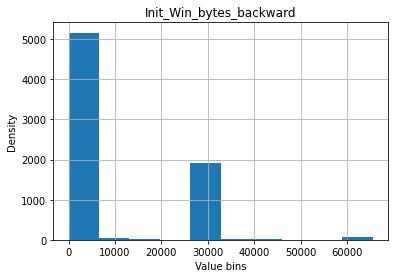

In [ ]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

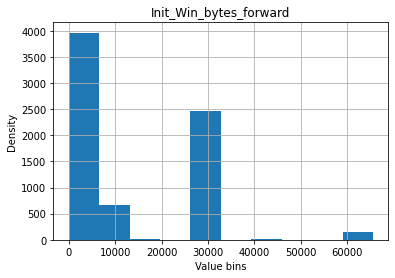

In [ ]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [ ]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2, errors='ignore')

In [ ]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3559, 1: 1527}

###DecisionTreeClassifier



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.95088409, 0.96856582, 0.956778  , 0.96856582, 0.95874263,
       0.95481336, 0.96653543, 0.95866142, 0.95275591, 0.95866142])

In [ ]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Average Packet Size <= 1.00
|   |--- Fwd IAT Std <= 3439176.00
|   |   |--- class: 0
|   |--- Fwd IAT Std >  3439176.00
|   |   |--- Fwd IAT Min <= 9652.50
|   |   |   |--- class: 1
|   |   |--- Fwd IAT Min >  9652.50
|   |   |   |--- class: 0
|--- Average Packet Size >  1.00
|   |--- Total Length of Fwd Packets <= 36594.00
|   |   |--- class: 0
|   |--- Total Length of Fwd Packets >  36594.00
|   |   |--- class: 1



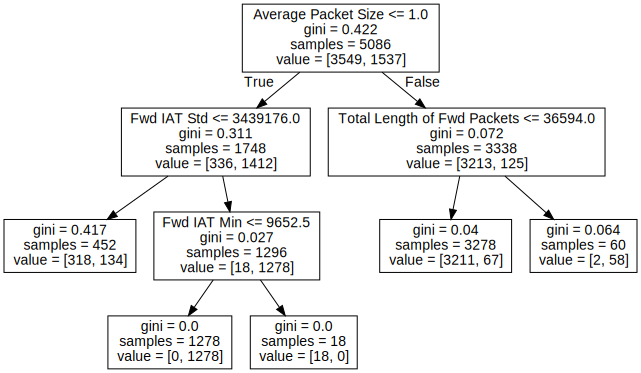

In [ ]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{1: 300}

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Flow Byts/s
- Fwd Header Len
- Fwd IAT Mean
- Fwd Pkt Len Max
- Fwd Pkt Len Mean
- ...
Feature names seen at fit time, yet now missing:
- Average Packet Size
- Flow Bytes/s
- Flow IAT Mean
- Flow Packets/s
- Fwd Packet Length Max
- ...

  warnings.warn(message, FutureWarning)


array([[  0,   0],
       [150, 150]])

###Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [ ]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#13	0.083	Flow Bytes/s
2.	#51	0.080	Average Packet Size
3.	#38	0.063	Max Packet Length
4.	#39	0.062	Packet Length Mean
5.	#7	0.056	Fwd Packet Length Mean
6.	#23	0.053	Fwd IAT Min
7.	#61	0.051	Subflow Fwd Bytes
8.	#52	0.050	Avg Fwd Segment Size
9.	#3	0.046	Total Length of Fwd Packets
10.	#15	0.035	Flow IAT Mean
11.	#5	0.033	Fwd Packet Length Max
12.	#21	0.029	Fwd IAT Std
13.	#14	0.024	Flow Packets/s
14.	#33	0.023	Fwd Header Length
15.	#0	0.021	Flow Duration
16.	#35	0.021	Fwd Packets/s
17.	#16	0.020	Flow IAT Std
18.	#20	0.018	Fwd IAT Mean
19.	#22	0.017	Fwd IAT Max
20.	#34	0.015	Bwd Header Length


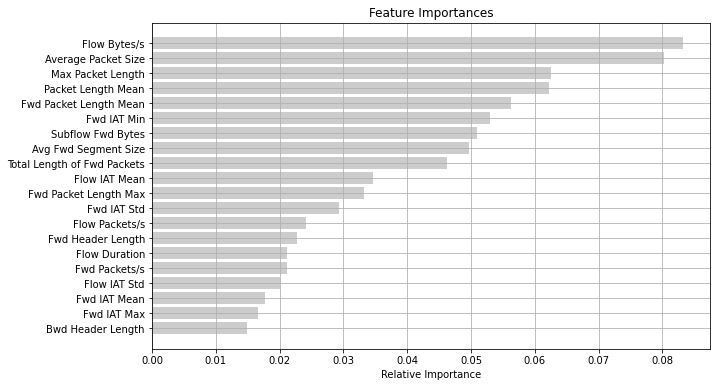

In [ ]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1508,   20],
       [  20,  633]])

In [ ]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Subflow Fwd Bytes',
 'Avg Fwd Segment Size',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Flow Packets/s',
 'Fwd Header Length',
 'Flow Duration',
 'Fwd Packets/s',
 'Flow IAT Std',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Bwd Header Length']

In [ ]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes',
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd Packet Length Max',
 'Fwd IAT Std',
 'Flow Packets/s']

In [ ]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


In [ ]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3],
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

CPU times: user 13.3 s, sys: 41.4 ms, total: 13.3 s
Wall time: 13.3 s


## Final model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5086, 10) (5086,)
(2181, 10) (2181,)


In [ ]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [ ]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#2	0.335	Max Packet Length
2.	#1	0.304	Average Packet Size
3.	#8	0.152	Fwd IAT Std
4.	#5	0.064	Total Length of Fwd Packets
5.	#6	0.037	Flow IAT Mean
6.	#4	0.032	Fwd IAT Min
7.	#0	0.028	Flow Bytes/s
8.	#9	0.025	Flow Packets/s
9.	#3	0.019	Fwd Packet Length Mean
10.	#7	0.003	Fwd Packet Length Max


In [ ]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1513,   25],
       [  29,  614]])

In [ ]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9752407152682255
Precision = 0.9608763693270735
Recall = 0.9548989113530326
F1 = 0.9578783151326052


In [ ]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

In [ ]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [ ]:
dataframe1=pd.read_csv('/content/drive/MyDrive/slowloris.pcap_Flow.csv',engine='python',encoding='latin1')

In [ ]:
print(dataframe1.columns)

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

In [ ]:
dataframe1.replace('Infinity', -1, inplace=True)
dataframe1[["Flow Byts/s", "Flow Pkts/s"]] = dataframe1[["Flow Byts/s", "Flow Pkts/s"]].apply(pd.to_numeric)

In [ ]:
dataframe1.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

In [ ]:
print(dataframe1['Label'])
dataframe1['Label'] = dataframe1['Label'].apply(lambda x: 0 if x=='BENIGN' else 1)
y_test = dataframe1['Label'].values
excluded = [
            'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
        'TotLen Bwd Pkts',
       'Fwd Pkt Len Min',  'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std',  'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
         'Fwd IAT Max',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags',  'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min',  'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label'

       ]
X_test = dataframe1.drop(columns=excluded, errors='ignore')
print(X_test.shape, y_test.shape)

0      No Label
1      No Label
2      No Label
3      No Label
4      No Label
         ...   
295    No Label
296    No Label
297    No Label
298    No Label
299    No Label
Name: Label, Length: 300, dtype: object
(300, 10) (300,)


In [ ]:
X_test.head()

,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Flow Byts/s,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Fwd Header Len,Pkt Len Max,Pkt Size Avg
0,275.0,168.0,22.916667,2.528723,9.886356e+06,7.184148e+06,38.0,260,168.0,11.956522
1,274.0,168.0,22.833333,2.519538,9.886319e+06,7.184201e+06,70.0,260,168.0,11.913043
2,277.0,168.0,23.083333,2.547134,9.886287e+06,7.184243e+06,31.0,260,168.0,12.043478
3,275.0,168.0,22.916667,2.528748,9.886268e+06,7.184264e+06,54.0,260,168.0,11.956522
4,274.0,168.0,22.833333,2.519559,9.886247e+06,7.184285e+06,36.0,260,168.0,11.913043


In [ ]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(predict)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Flow Byts/s
- Fwd Header Len
- Fwd IAT Mean
- Fwd Pkt Len Max
- Fwd Pkt Len Mean
- ...
Feature names seen at fit time, yet now missing:
- Average Packet Size
- Flow Bytes/s
- Flow IAT Mean
- Flow Packets/s
- Fwd Packet Length Max
- ...

  warnings.warn(message, FutureWarning)


In [ ]:
result[result['Predict'] == 1]

,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Flow Byts/s,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Min,Fwd Header Len,Pkt Len Max,Pkt Size Avg,Predict
0,275.0,168.0,22.916667,2.528723,9.886356e+06,7.184148e+06,38.0,260,168.0,11.956522,1
1,274.0,168.0,22.833333,2.519538,9.886319e+06,7.184201e+06,70.0,260,168.0,11.913043,1
2,277.0,168.0,23.083333,2.547134,9.886287e+06,7.184243e+06,31.0,260,168.0,12.043478,1
3,275.0,168.0,22.916667,2.528748,9.886268e+06,7.184264e+06,54.0,260,168.0,11.956522,1
4,274.0,168.0,22.833333,2.519559,9.886247e+06,7.184285e+06,36.0,260,168.0,11.913043,1
...,...,...,...,...,...,...,...,...,...,...,...
145,277.0,168.0,23.083333,2.635491,9.554881e+06,7.574734e+06,23.0,260,168.0,12.043478,1
146,277.0,168.0,23.083333,2.635495,9.554868e+06,7.574750e+06,22.0,260,168.0,12.043478,1
147,275.0,168.0,22.916667,2.616471,9.554854e+06,7.574769e+06,22.0,260,168.0,11.956522,1
148,276.0,168.0,23.000000,2.625988,9.554840e+06,7.574789e+06,22.0,260,168.0,12.000000,1


# New section

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
Download the dataset from Github to Google Colab and unzip it.

!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true -O dataset.zip
!unzip -u dataset.zip
We use "engine=python" to avoid the "UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 11: invalid start byte" encoding error.

df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python')
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv file contains 458968 records, 85 columns.

df.shape
(458968, 85)
The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.

df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape
(458968, 84)
When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

df['Label'].unique()
array(['BENIGN', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection', nan], dtype=object)
df['Label'].value_counts()
BENIGN                        168186
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Web Attack – Sql Injection        21
Name: Label, dtype: int64
Delete blank records.

df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape
(170366, 84)
The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)
Replace the NaN values and infinity values with -1.

df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)
Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features
['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

SyntaxError: ignored

In [ ]:
          str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)


     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.


    ml=["Naive Bayes","QDA","Random Forest","ID3","AdaBoost","MLP","Nearest Neighbors"]
    temp=0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=True)
    for c in range(2):
        for b in range(4):
            axes[c, b].boxplot(a[temp] )
            axes[c, b].set_title(str(j[0:-4])+" - "+str(ml[temp]),fontsize=7)
            axes[c, b].set_ylabel(("F measure"))
            temp+=1
            if temp==7:
                break
        if temp==7:
            break
    plt.savefig(folder_name+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    plt.show()
    print("\n------------------------------------------------------------------------------------------------------\n\n")

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds"

In [ ]:
from google.colab import drive drive.mount('/content/drive')


SyntaxError: ignored

In [ ]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_1.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks")# CSV files names: #The names of the files in the attacks folder are taken and assigned to a list (csv_files).
path=".\\attacks\\"
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_1/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
features={"Bot":["Bwd Packet Length Mean","Flow IAT Max","Flow Duration","Flow IAT Min","Label"],
"DDoS":["Bwd Packet Length Std","Total Backward Packets","Fwd IAT Total","Flow Duration","Label"],
"DoS GoldenEye":["Flow IAT Max","Bwd Packet Length Std","Flow IAT Min","Total Backward Packets","Label"],
"DoS Hulk":["Bwd Packet Length Std","Fwd Packet Length Std","Fwd Packet Length Max","Flow IAT Min","Label"],
"DoS Slowhttptest":["Flow IAT Mean","Fwd Packet Length Min","Bwd Packet Length Mean","Total Length of Bwd Packets","Label"],
"DoS slowloris":["Flow IAT Mean","Total Length of Bwd Packets","Bwd Packet Length Mean","Total Fwd Packets","Label"],
"FTP-Patator":["Fwd Packet Length Max","Fwd Packet Length Std","Fwd Packet Length Mean","Bwd Packet Length Std","Label"],
"Heartbleed":["Total Backward Packets","Fwd Packet Length Max","Flow IAT Min","Bwd Packet Length Max","Label"],
"Infiltration":["Fwd Packet Length Max","Fwd Packet Length Mean","Flow Duration","Total Length of Fwd Packets","Label"],
"PortScan":["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration","Label"],
"SSH-Patator":["Fwd Packet Length Max","Flow Duration","Flow IAT Max","Total Length of Fwd Packets","Label"],
"Web Attack":["Bwd Packet Length Std","Total Length of Fwd Packets","Flow Bytes/s","Flow IAT Max","Label"]}

seconds=time.time()#time stamp for all processing time



with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    a=[]

    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm

        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)
    df["Label"]=attack_or_not


    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]


    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test).
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)

            #makes "classification report" and assigns the precision, f-measure, and recall values.s.

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')





            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )



        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)),
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)


     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.


    ml=["Naive Bayes","QDA","Random Forest","ID3","AdaBoost","MLP","Nearest Neighbors"]
    temp=0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=True)
    for c in range(2):
        for b in range(4):
            axes[c, b].boxplot(a[temp] )
            axes[c, b].set_title(str(j[0:-4])+" - "+str(ml[temp]),fontsize=7)
            axes[c, b].set_ylabel(("F measure"))
            temp+=1
            if temp==7:
                break
        if temp==7:
            break
    plt.savefig(folder_name+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    plt.show()
    print("\n------------------------------------------------------------------------------------------------------\n\n")

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")